# Virtual Distillation
In this main file, we run simulations where we perform the full VD protocol for the 3-copies case, and check the behavior under loss model. Several input states are tested. At the end we also implement dephasing and try it on Binomial States.

The functions used are in a separate file for readability, but all the formulas used throughout the file are detailed here.

In the tests file, we perform some scaling analysis both in the number of copies and the Fock number.

In [1]:
import qutip
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from functions import *

RUN_FOCK  = True # False
RUN_BINOM = True # False
RUN_CAT   = True # False
RUN_GKP   = True # False

N = 11 # Total dimension of the space. We will use three copies so N^3 size matrices

## Initial noisy Fock state preparation

Kraus operators $\hat A_k(t)=\dfrac{(1-e^{-\kappa t})^{k/2}}{\sqrt{k!}}e^{-\kappa \hat n t/2}\hat a^k$.
$$\hat\rho(t)=\sum_{k=0}^\infty\hat A_k(t)\hat\rho_0\hat A_k(t)^\dagger$$

with $\rho_0=\ket n\bra n$


For multi-mode $\hat a, \hat b, \dots,\hat c$ we define the same way $\hat A_k, \hat B_k,\dots \hat C_k$ and
$$\hat\rho(t)=\sum_{k=0}^\infty\sum_{l=0}^\infty\dots\sum_{m=0}^\infty\hat A_k\hat B_l\dots\hat C_m\hat\rho_0 \hat A_k^\dagger\hat B_l^\dagger\dots\hat C_m^\dagger$$

In [2]:
n = 3     # number of photons in the initial state
T_1 = 500 # μs
kappa = 1/T_1 # decay rate of the cavity (only for losses)
t_max = 100 # μs (such that κt ~ 0.1)

nb_samples = 20
t_list = np.linspace(0,t_max,nb_samples)
    
# Here we create the noisy Fock states
rho_list = create_states(N, t_list, rho_0 = qutip.fock_dm(N,n), kappa=kappa)

Because the resulting initial states are diagonal in the Fock basis, i.e. of the form $\sum_kc_k\ket k\bra k$, we can represent them using a bar chart of the coefficients $c_k$.

Text(0.5, 1.0, 't=100.000')

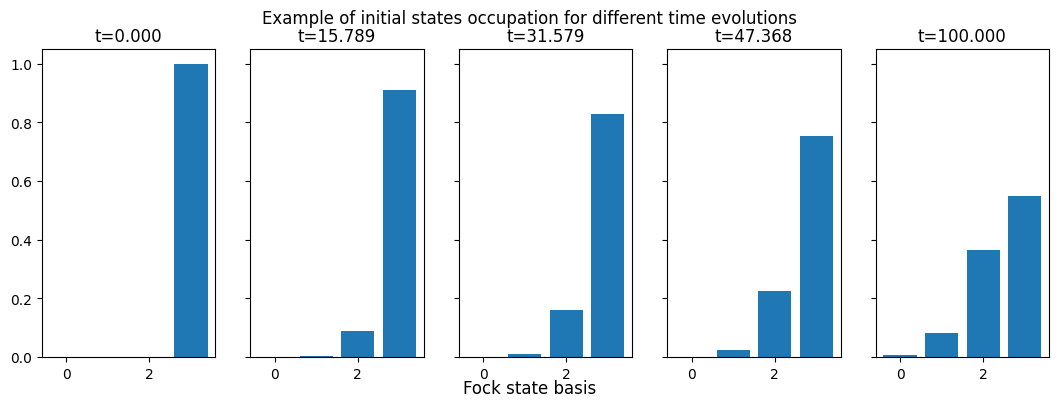

In [3]:
nb_plots = 4
f, axes = plt.subplots(1, nb_plots+1, sharey=True, figsize=(13,4))
f.suptitle("Example of initial states occupation for different time evolutions\n")
f.supxlabel("Fock state basis")
for i in range(nb_plots):
    axes[i].bar(np.arange(n+1),np.abs(np.diag(rho_list[3*i]))[:n+1])
    axes[i].set_title(f't={t_list[3*i]:.3f}')
axes[nb_plots].bar(np.arange(n+1),np.abs(np.diag(rho_list[nb_samples-1]))[:n+1])
axes[nb_plots].set_title(f't={t_list[nb_samples-1]:.3f}')

## Virtual Distillation protocol
We perform the protocol on $M=3$ copies of the noisy input state using the diagonalizing method. This is done by applying three successive beam splitter operations on the 3-mode system, resulting in the following gate:
$$\hat{\mathcal F}_3=e^{\frac{i\pi}4(\hat a_1^\dagger \hat a_2+\hat a_2^\dagger \hat a_1)}e^{i\arcsin{(\frac1{\sqrt3})}(\hat a_3^\dagger \hat a_2+\hat a_2^\dagger \hat a_3)}e^{\frac{i\pi}4(\hat a_3^\dagger \hat a_1+\hat a_1^\dagger \hat a_3)}$$

To assess the robustness of the protocol, we add some coherent error on the angle of the beam splitter, modelized by a Gaussian distribution.

$$\hat{\mathcal F}_3(\varepsilon)=e^{i\left(\frac{\pi}4+\varepsilon_1\right)(\hat a_1^\dagger \hat a_2+\hat a_2^\dagger \hat a_1)}e^{i\left(\arcsin{(\frac1{\sqrt3})}+\varepsilon_2\right)(\hat a_3^\dagger \hat a_2+\hat a_2^\dagger \hat a_3)}e^{i\left(\frac{\pi}4+\varepsilon_3\right)(\hat a_3^\dagger \hat a_1+\hat a_1^\dagger \hat a_3)}$$
with
$$\varepsilon=(\varepsilon_1,\varepsilon_2,\varepsilon_3)\sim \mathcal N(0,\sigma)$$

Here is where we compute the noisy $\mathcal F_3$ gates (this is the most costly operation). After performing the whole protocol, we will average the results and compute their standard deviation.

In [4]:
nb_F_samples = 20
eps_std = np.pi/4 * 3/100 # 3% of pi/4
initial_sin_angles = np.sqrt((1/2,1/3,1/2)) # exact values

try: # to avoid recalculating everything when rerunning only some of the cells of the Notebook
    recalc += 1
except NameError:
    if RUN_FOCK or RUN_BINOM or RUN_CAT or RUN_GKP:
        noise_list = np.random.normal(0,eps_std,(nb_F_samples,3))
        F_list = [] # list of triplets of beam splitters
        for (i,noise) in enumerate(noise_list):
            if (i%1==0): print(f"{i+1}/{nb_F_samples}", end=" ")
            # Here we create the F3 gates with the noisy angles
            F_list.append(create_F3(N, initial_sin_angles, noise))
        recalc = 0

1/20 2/20 3/20 4/20 5/20 6/20 7/20 8/20 9/20 10/20 11/20 12/20 13/20 14/20 15/20 16/20 17/20 18/20 19/20 20/20 

After applying the diagonalizing gate, we obtain
$$\tilde \rho=\hat{\mathcal F}_3\rho^{\otimes 3}\hat{\mathcal F}_3^\dagger$$
We can then measure $\hat n_1$, $\hat n_2$, $\hat n_3$ and by repeating the experiment retrieve
$$ \operatorname{den}=\left\langle\hat{\mathcal R_3}\right\rangle =\left\langle\exp\left(\frac{2i\pi}3(\hat n_1+2\hat n_2)\right)\right\rangle \quad\text{and}\quad \operatorname{num}=\left\langle\hat n^{(3)}\hat{\mathcal R_3}\right\rangle = \left\langle\frac{\hat n_1+\hat n_2+\hat n_3}3e^{\frac{2i\pi}3(\hat n_1+2\hat n_2)}\right\rangle$$
Instead of averaging on many experiments, here we directly compute the expectation values (this should be faster thanks to qutip).
We compare
$$\frac{\operatorname{num}}{\operatorname{den}}\;,\quad \frac{\operatorname{tr}\left(\hat n\hat\rho^3\right)}{\operatorname{tr}\left(\hat\rho^3\right)}\;,\quad\text{and}\quad \operatorname{tr}(\hat n\hat\rho)$$
which correspond to computed result, theoretical result and no-VD result.

$$\Rightarrow\left\langle\hat n\right\rangle_{VD}=\frac{\left\langle\frac{\hat n_1+\hat n_2+\hat n_3}3e^{\frac{2i\pi}3(\hat n_1+2\hat n_2)}\right\rangle}{\left\langle e^{\frac{2i\pi}3(\hat n_1+2\hat n_2)}\right\rangle}$$

During the protocol, we add incoherent losses and dephasing in between each beam splitter gate. The losses are proven to commute with the beam splitter operators, and dephasing shouldn’t have an effect since Fock state are rotation-invariant, so the expected curve should simply appear as shifted to the left compared to the one without losses.

In [5]:
if RUN_FOCK:
    uncoherent_t_loss = 10 # μs
    kappa_phi = kappa # dephasing rate
    result, result_loss, result_th = perform_protocol(N, rho_list, F_list,
                        losses=False, losses_gamma=kappa*uncoherent_t_loss,
                        dephasing=True, dephasing_gamma=kappa_phi*uncoherent_t_loss,
                        print_progression=True)
    result_th_3, result_th_4, result_withoutVD = result_th

# To add uncoherent losses, switch losses to True

1/20 2/20 3/20 4/20 5/20 6/20 7/20 8/20 9/20 10/20 11/20 12/20 13/20 14/20 15/20 16/20 17/20 18/20 19/20 20/20 

We have to be careful that the numerical errors coming from truncation of Hilbert space are not too important : check that S is doing the appropriate thing (only zeroes and ones should appear below (up to phase))

In [6]:
bs1, bs2, bs3 =create_F3(N, initial_sin_angles, np.zeros(3))
           
check_S_operator(N, n, bs1, bs2, bs3)

True
<233|S|233> =  0.0
<233|S|323> =  0.0
<233|S|332> =  1.0
<323|S|233> =  1.0000000000000002
<323|S|323> =  0.0
<323|S|332> =  0.0
<332|S|233> =  0.0
<332|S|323> =  1.0
<332|S|332> =  0.0


## Plots

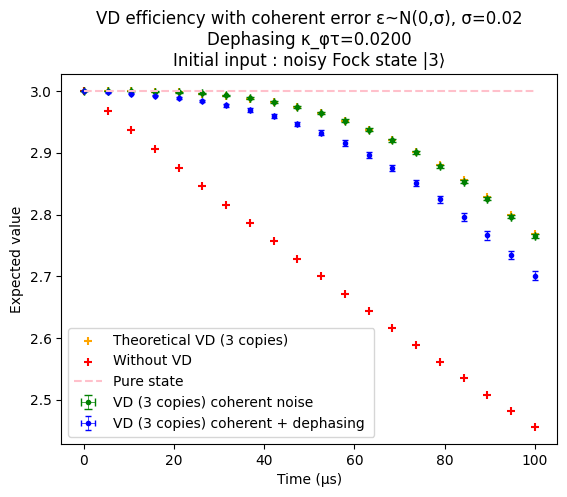

In [7]:
if RUN_FOCK:
    plot_all(t_list, result, result_loss,
             [(result_th_3, "Theoretical VD (3 copies)"),
              (result_withoutVD, "Without VD"), 
              #(result_th_4, "Theoretical VD (4 copies)") # 4 copies
              ], remove_extreme=None, #(4,1.5),
             eps_std=eps_std, kappa=kappa,
             gamma_loss = None, #kappa*uncoherent_t_loss,
             gamma_dephasing = kappa_phi*uncoherent_t_loss,
             show_curves=None, title="Fock state |3⟩")
    

# To add result without VD, toggle the comment in the plot_all call above
# To show also theoretical curves, switch show_curves to n (works only for Fock states)
# Here we plot with dephasing, the theoretical explanation is given below

# -- Other input states --
We try with other input states :
$$\ket\psi=\frac{\ket0+\ket4}{\sqrt2}$$
and
$$\ket\phi=\frac{\ket\alpha+\ket{-\alpha}}{\sqrt2}$$
and later GKP

### Binomial

<BarContainer object of 11 artists>

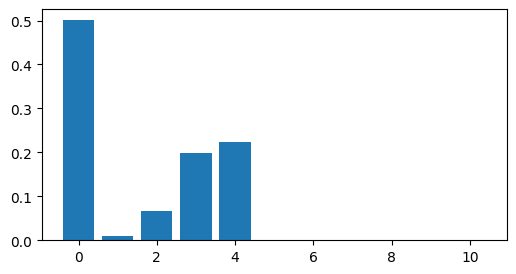

In [8]:
rho_binomial = qutip.ket2dm((qutip.fock(N,0) + qutip.fock(N,4)).unit())

noisy_binomial_list = create_states(N, t_list, rho_binomial, kappa)
f, ax = plt.subplots(1, 1, sharey=True, figsize=(6,3))
ax.bar(np.arange(N), np.abs(np.diag(noisy_binomial_list[-1])))

In [9]:
if RUN_BINOM:
    result_binomial, result_binomial_loss,result_binomial_th = perform_protocol(N, noisy_binomial_list,
                                                                        F_list, losses=False)

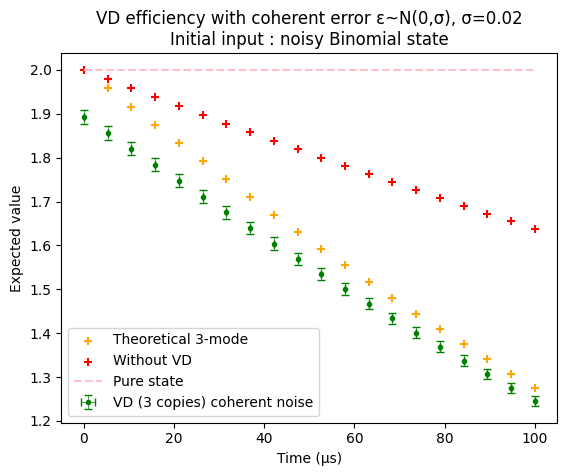

In [10]:
if RUN_BINOM:
    plot_all(t_list, result_binomial, result_binomial_loss,
             [(result_binomial_th[0], "Theoretical 3-mode"),
              (result_binomial_th[2],"Without VD"),
           # (result_binomial_th[1], "Theoretical 4-mode")
            ], (3,0.5), "Binomial state", 
             eps_std, gamma_loss=None)

The protocol does not yield an advantage…
The problem is that when losses occur, we have some extra $\ket3\bra3$, $\ket2\bra2$ terms but they are suppressed by VD, so the average photon number is decreased substantially. There is a huge eigenvector drift so the protocol is broken.

### Cat

In [11]:
alpha = np.sqrt(2)
rho_cat = qutip.ket2dm((qutip.coherent(N, alpha) + qutip.coherent(N, -alpha)).unit())

nb_samples_cat = 7 # less samples to avoid too long computation
t_list_cat = t_list[:nb_samples_cat]
noisy_cat_list = create_states(N, t_list_cat, rho_cat, kappa)
if RUN_CAT:
    result_cat, result_cat_loss, result_cat_th = perform_protocol(N, noisy_cat_list, 
                                        F_list[:nb_samples_cat], [1,3], losses=False)


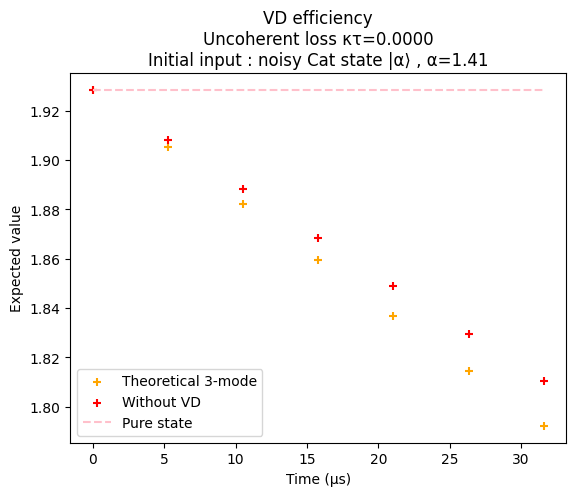

In [12]:
if RUN_CAT:
    plot_all(t_list_cat, result_cat, result_cat_loss, [(result_cat_th[1], "Theoretical 3-mode"), 
                        (result_cat_th[0],"Without VD" )], None, f"Cat state |α⟩ , α={alpha:.2f}",
                        gamma_loss=False, eps_std=eps_std, show_only_th=True)

### GKP

Finitely squeezed GKP state

$$\ket{0_\delta}=e^{-\delta^2\left(\hat n+\frac12\right)}\ket{0^{(\text{ideal})}}\qquad\text{where}\qquad \ket{0^{(\text{ideal})}}=\sum_{n=-\infty}^\infty\ket{2n\sqrt\pi}_q$$

Other form for small $\delta$:
$$\ket{0_\delta}\propto\sum_{s\in\mathbb Z}e^{-\pi s^2\tanh\delta^2}\hat D(2s\sqrt\pi)\hat S(-\ln\sqrt{\sinh\delta^2\cosh\delta^2})\ket0$$

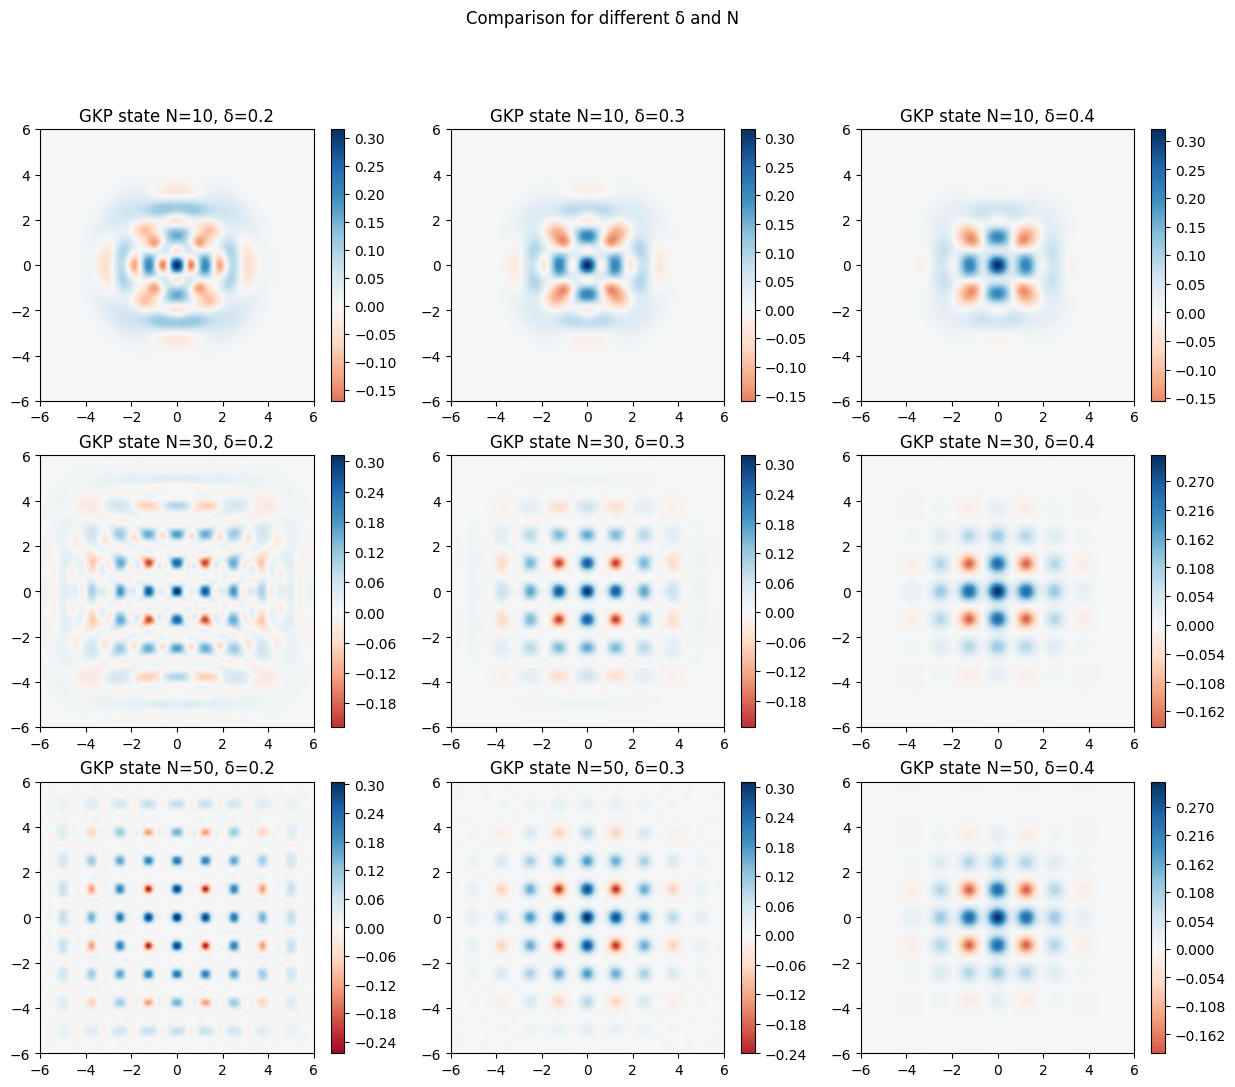

In [13]:
# We will now plot the GKP states for various squeezing parameters and Hilbert space truncations
N_ = 30
bound = 6
xvec = np.linspace(-bound,bound,200)
yvec = np.linspace(-bound,bound,200)
cmap='RdBu'

if RUN_GKP or True:
    N_list = [10, 30, 50]
    delta_list = [0.2, 0.3, 0.4]
    n_delta = len(delta_list)
    n_N = len(N_list)
    fig, axes = plt.subplots(n_N, n_delta, figsize=(5*n_delta,4*n_N))
    for (i, N_) in enumerate(N_list) :
        for (j, delta) in enumerate(delta_list):
            psi_gkp = gkp_state(delta, N_)
            plot_wigner(psi_gkp, xvec, yvec, fig, axes[i,j], cmap, f'GKP state N={N_}, δ={delta}')
            
    fig.suptitle("Comparison for different δ and N")
    plt.show()

The smaller the squeezing parameter is, the larger the Hilbert space truncation should be (the top plots and the middle left are not great).

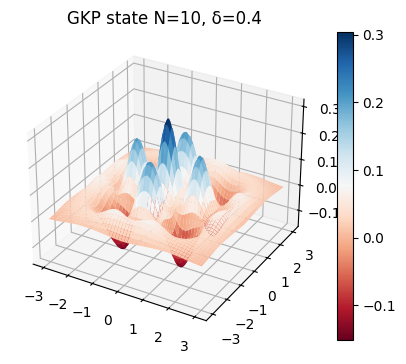

In [14]:
# 3D visualization of the Wigner function of a GKP state
def plot_wigner_3D(psi, xvec, yvec, fig, ax, cmap, title="Wigner"):
    rho = qutip.ket2dm(psi)
    wigner = qutip.wigner(rho, xvec, yvec)
    X = np.tile(xvec, (len(yvec), 1)).transpose()
    Y = np.tile(yvec, (len(xvec), 1))
    plot = ax.plot_surface(X,Y, wigner, cmap=cmap)
    ax.set_title(title)
    fig.colorbar(plot, ax=ax)

delta, N_ = 0.4, 10 # Not the best choice but we want to keep the plot simple
bound_3d = 3
xvec_3d = np.linspace(-bound_3d,bound_3d,200)
yvec_3d = np.linspace(-bound_3d,bound_3d,200)
fig, ax = plt.subplots(1, 1, figsize=(5,4), subplot_kw={"projection": "3d"})
plot_wigner_3D(gkp_state(delta, N_), xvec_3d, yvec_3d, fig, ax, cmap, f'GKP state N={N_}, δ={delta}')

According to _Equivalence of approximate Gottesman-Kitaev-Preskill codes_ (Takaya Matsuura, Hayata Yamasaki, Masato Koashi), for a finitely squeezed GKP with squeezing parameter $\sigma$, the average photon number is approximately $\frac1{4\sigma^2}-\frac12$ when $-10\log_{10}(2\sigma^2)\gg1$
(Here no clear link between $\sigma$ and $\delta$, probably just a constant factor).

In [15]:
if RUN_GKP:
    rho_gkp = qutip.ket2dm(psi_gkp)
    N_ = rho_gkp.shape[0]
    print(qutip.expect(qutip.num(N_), rho_gkp), 1/(4*delta**4)-1/2)

2.6426925175432276 9.265624999999998


Now we test the Virtual Distillation protocol.

In [16]:
#N = 10
t_list_gkp = np.linspace(0, 0.5, 10)
delta = 0.4
psi_gkp = gkp_state(delta, N)
rho_gkp = qutip.ket2dm(psi_gkp)
noisy_gkp_list = create_states(N, t_list_gkp, rho_gkp, kappa)

if RUN_GKP:
    result_gkp, result_gkp_loss, result_gkp_th = perform_protocol(N,noisy_gkp_list, F_list[:10],
                                                                  [1,3], losses=False)

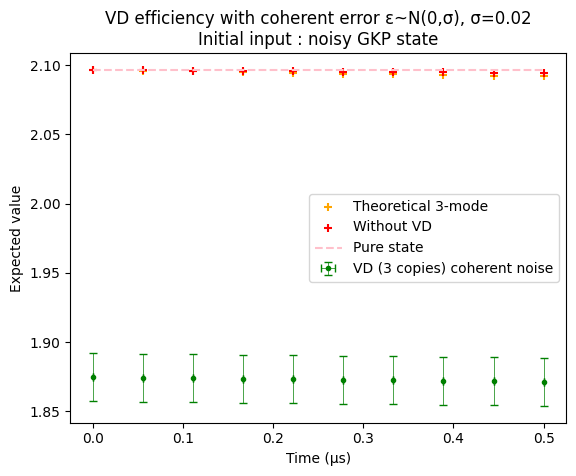

In [17]:
# show results
if RUN_GKP:
    plot_all(t_list_gkp, result_gkp, result_gkp_loss, [(result_gkp_th[1], "Theoretical 3-mode"),
                        (result_gkp_th[0], "Without VD")], None, "GKP state", 
                        eps_std=eps_std,gamma_loss=None, show_only_th=False)

As for Binomial states, the protocol does not work at all due to dominant eigenvector drift.

### Conclusion
In all the other input states, the protocol yields worse results than doing a direct measurement. This is due to the fact that the dominant eigenvector endures an important drift towards low number states, and the protocol exponentially suppresses contributions from some high number states.

## --- Adding dephasing ---

Kraus operators
$$\hat B_\ell = \frac{(\kappa_\phi t)^{\ell/2}}{\sqrt{\ell!}}e^{-\kappa_\phi\hat n^2t/2}\hat n^\ell$$

$$\rho(t)=e^{t\mathcal L_{\kappa_\phi}}\rho(0)=\sum_{\ell=0}^\infty\hat B_\ell\rho(0)\hat B_\ell^\dagger$$

Dephasing only makes sense for states other than Fock states, because otherwise there is a rotation symmetry. However, there are no other input states that seem to work well for now.

We still try to implement it for binomial states, knowing that the protocol will perform badly.

In [18]:
N = 11
t_list_dephase = np.linspace(0, 500, 20)
rho_0 = qutip.ket2dm((qutip.fock(N, 0) + qutip.fock(N,4)).unit())
rho_list_dephase = create_states_dephasing(N, t_list_dephase, rho_0, kappa)

Text(0.5, 0.98, 'Wigner functions of noisy binomial state\n(|0⟩ + |4⟩)/√2 after dephasing channel')

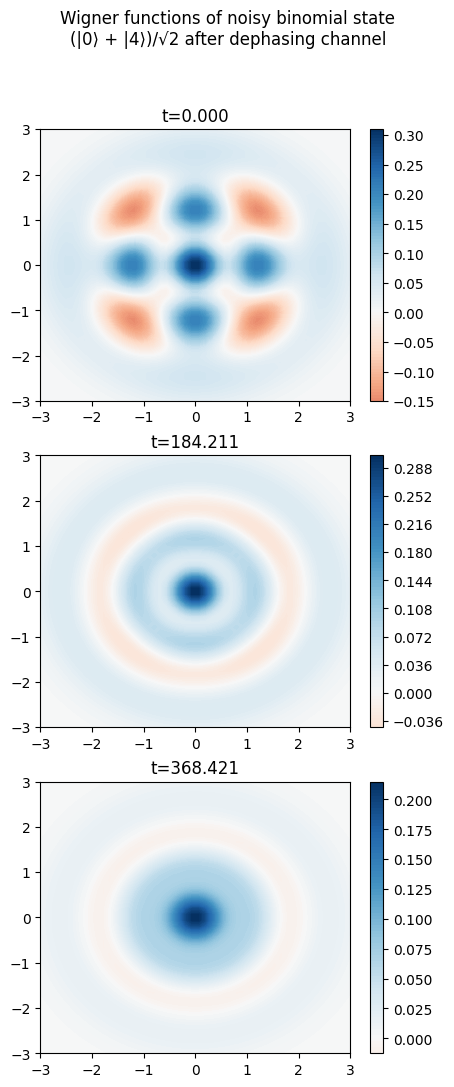

In [19]:
bound = 3
xvec, yvec = np.linspace(-bound,bound,50), np.linspace(-bound,bound,50)
# create several plots for different elements of rho_list
nb_plots = 3
f, axes = plt.subplots(nb_plots, 1, figsize=(5, 4*nb_plots))
for j,i in enumerate(range(0,20,7)):
    plot_wigner(rho_list_dephase[i], xvec, yvec, f, axes[j], 'RdBu', f"t={t_list_dephase[i]:.3f}", density=True)
f.suptitle("Wigner functions of noisy binomial state\n(|0⟩ + |4⟩)/√2 after dephasing channel")

In [20]:
if RUN_BINOM:
    uncoherent_t_loss = 5 # μs
    kappaphi = kappa/3
    noisy_binomial_list = create_states(N, t_list, rho_binomial, kappa)
    result_binomial, result_binomial_loss, result_binomial_th = perform_protocol(N, noisy_binomial_list,
            F_list, [3,1], losses=True, losses_gamma=kappa*uncoherent_t_loss,
            dephasing=True, dephasing_gamma=kappaphi*uncoherent_t_loss,
            print_progression = True)

1/20 2/20 3/20 4/20 5/20 6/20 7/20 8/20 9/20 10/20 11/20 12/20 13/20 14/20 15/20 16/20 17/20 18/20 19/20 20/20 

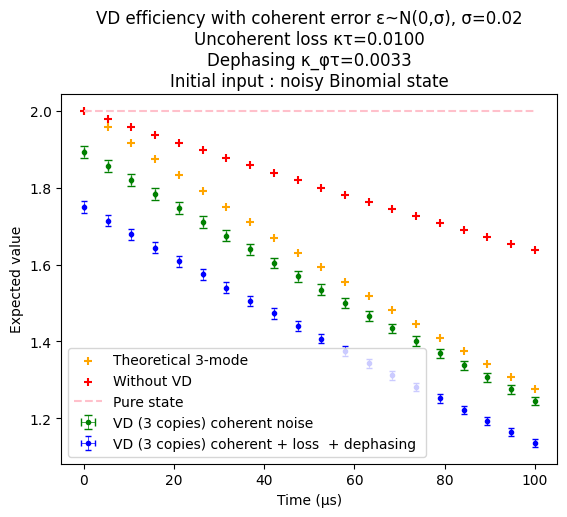

In [21]:
if RUN_BINOM:
    plot_all(t_list, result_binomial, result_binomial_loss, [(result_binomial_th[0], "Theoretical 3-mode"),
                        (result_binomial_th[1], "Without VD")], None, "Binomial state",
                        eps_std=eps_std, gamma_loss=kappa*uncoherent_t_loss,
                         gamma_dephasing=kappaphi*uncoherent_t_loss,
                           show_only_th=False)